AUD/CAD
[-14.27092361]
[-14.49760437]
[-14.25208282]
[-14.06387329]
[-13.9578743]
[-13.90342331]
[-13.83226013]
[-13.73898697]
[-13.62453079]
[-13.5644722]
[-13.59486771]
[-13.59082794]
[-13.52444458]
[-13.46385574]


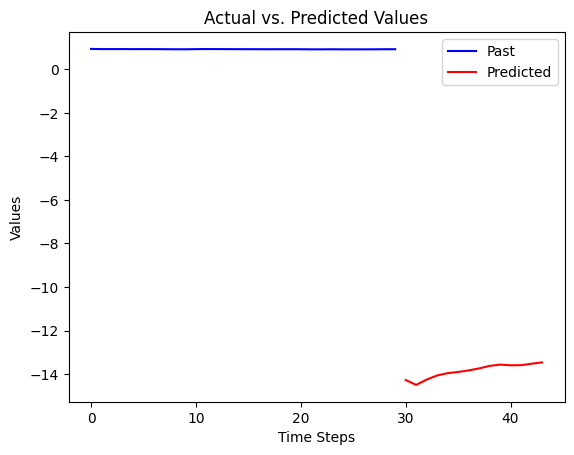

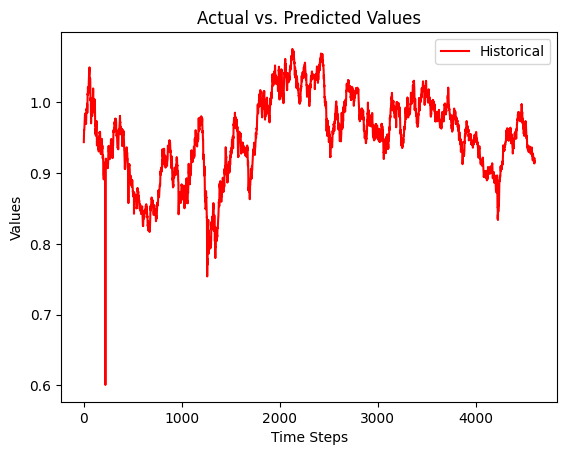

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import copy
import json
import os

'''LSTM class'''
class LSTM(nn.Module):
    def __init__(self, input_num_cols, hidden_size, num_layers=1, device="cpu"):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # add lstm layers
        self.lstm = nn.LSTM(
            input_num_cols,
            hidden_size,
            num_layers,
            batch_first=True)
        # add fully-connected linear layer
        self.fc = nn.Linear(hidden_size, input_num_cols)

    def forward(self, x):
      # hidden state
      h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
      #initial cell state
      c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
      out, _ = self.lstm(x, (h0, c0))

      # filter out everything except the last timestep’s output
      out = self.fc(out[:, -1, :])
      return out


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

directory = '/Users/jenniferchen/Desktop/code/fx-forecast/api/'

def get_model_path(currency_pair):
    # currency_pair = currency_pair.replace('/', '_')
    currency_pair = "AUD_CAD"
    dir_models = directory + 'trained_models/'

    files = set(os.listdir(dir_models))

    for file in files:
        if currency_pair in file:
            model_path = f'{directory}trained_models/{file}'
            return model_path
    return None

def get_model(model_path):
    model_name = model_path.split('/')[-1][:-3]

    params_fpath = f'{directory}model_metadata/' + model_name
    metadata_fpath = '/Users/jenniferchen/Desktop/code/fx-forecast/api/model_metadata/AUD_MXN2'
    f = open(metadata_fpath)
    metadata= json.load(f)

    num_cols = 1
    num_lstm_units = 100
    num_lstm_layers = 3

    model = LSTM(num_cols, num_lstm_units, num_lstm_layers, device)
    return model, metadata

def convert_to_np(df, num_cols, num_dates):
    df.sort_values(by=['date'], ascending=True, inplace=True)
    data_np = df['rate'].to_numpy()

    # shape for 2D array
    shape = (num_cols, num_dates)

    # reshape the array to 3D
    data_np = data_np.reshape(shape).astype(np.float32)
    data_np = data_np.transpose()
    print(f"Data shape: {data_np.shape}")
    return data_np

def predict(model, metadata, historical_data):
    lookback = metadata['lookback']
    num_cols = 1

    model.eval()
    prediction_list = []

    num_dates = len(historical_data)

    data_np = convert_to_np(historical_data, 1, num_dates)

    x_indices = np.arange(lookback)[:, None] + np.arange(len(data_np) - lookback)
    x = data_np[x_indices]
    x = np.transpose(x, (1, 0, 2))

    # create the labels
    y = data_np[lookback:]
    generator = DataLoader(TensorDataset(torch.from_numpy(x), torch.from_numpy(y)), batch_size=1, shuffle=False)

    with torch.no_grad():
        for i, data in enumerate(generator):
          if i == 0:
            inputs, _ = data
            prediction_list = copy.deepcopy(inputs.numpy()).reshape(lookback, 1)
            inputs = inputs.to(device)
          else:
            inputs =copy.deepcopy(prediction_list[-lookback:])
            inputs = inputs.reshape((1, lookback, num_cols))
            inputs = torch.from_numpy(inputs).to(device)
          output = model(inputs).cpu().numpy()
          prediction_list = np.append(prediction_list, output, axis=0)

    prediction_list = prediction_list[lookback:]
    return prediction_list


def forecast_future_sequence(num_prediction, model, input_data, num_cols, lookback):

    prediction_list = input_data[-lookback:]
    prediction_list = prediction_list.reshape((lookback, 1))

    with torch.no_grad():
        for _ in range(num_prediction):
            x = copy.deepcopy(prediction_list[-(lookback):])
            x = x.reshape((1, lookback, num_cols))
            x = torch.from_numpy(x)
            x = x.to(torch.float32).to(device)
            output = model(x)
            # print(f"in: {x[-1, -1]} out: {output}")
            # exit(0)
            prediction_list = np.append(prediction_list, output.cpu().numpy(), axis=0)
        prediction_list = prediction_list[lookback:]

    return prediction_list


def graph_predicted_and_actual_historial(predictions, test_data_y):
    p = predictions[-365:]
    actual = test_data_y[-365:]

    time_steps = [i for i in range(len(p))]
    plt.plot(time_steps, p, color='blue', label='Predicted Rates')
    plt.plot(time_steps, actual, color='red', label='Historical Rates')

    plt.xlabel('Day #')
    plt.ylabel('Exchange Rate')
    plt.title('Predicted Values')

    plt.legend()
    plt.show()


def graph_forecasted_sequence(num_prediction, model, lookback, forex_df):
    '''Displaying Forecasted Future Sequence'''

    num_cols = 1
    initial_lookback = forex_df['rate'][-lookback:].to_numpy()
    forecast = forecast_future_sequence(num_prediction, model, initial_lookback, num_cols, lookback)
    for i, val in enumerate(forecast):
        # if val == 0:
        #     if i == 0:
        #         forecast[i, 0] = forecast[i+1, 0]
        #     elif i == num_prediction - 1:
        #         forecast[i, 0] = forecast[i-1, 0]
        #     else:
        #         forecast[i, 0] = (forecast[i+1, 0] + forecast[i-1, 0]) / 2
        print(val)

    # time_steps = [i for i in range(len(forex_df['rate']) + len(forecast))]
    # plt.plot(time_steps[:len(forex_df['rate'])], list(forex_df['rate']), label='Past', color='blue')
    # plt.plot(time_steps[len(forex_df['rate']):], forecast[:, 0], label='Predicted', color='red')

    time_steps = [i for i in range(len(initial_lookback) + len(forecast))]
    plt.plot(time_steps[:len(initial_lookback)], initial_lookback, label='Past', color='blue')
    plt.plot(time_steps[len(initial_lookback):], forecast[:, 0], label='Predicted', color='red')

    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title('Actual vs. Predicted Values')

    plt.legend()
    plt.show()

def graph_historical(forex_df):
    historical = list(forex_df['rate'])
    time_steps = [i for i in range(len(historical))]

    plt.plot(time_steps, historical, label='Historical', color='red')

    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title('Actual vs. Predicted Values')

    plt.legend()
    plt.show()


def load_forex_df(fname):
    forex_df = pd.read_csv(fname, usecols=['slug', 'date', 'high', 'low', 'currency'])

    print(currency_pair)

    forex_df = forex_df[forex_df['slug'].isin([currency_pair])]

    forex_df['date'] = pd.to_datetime(forex_df['date'])
    forex_df.sort_values(by=['slug', 'date'], ascending=True, inplace=True)

    avgs = pd.DataFrame()
    avgs['rate'] = (forex_df['high'] + forex_df['low'])/2
    forex_df = pd.concat([avgs, forex_df], axis=1)

    forex_df = forex_df.drop('high', axis=1)
    forex_df = forex_df.drop('low', axis=1)
    return forex_df

if __name__ == "__main__":

    fname = directory + "model_notebooks/" + "forex.csv"
    forex_df = load_forex_df(fname)

    currency_pair = "AUD/CAD"
    # model_path = get_model_path(currency_pair)
    # print(f"Model path: {model_path}")

    model_path = "/Users/jenniferchen/Desktop/code/fx-forecast/api/model_notebooks/USD_ZMW0.pt"

    model, metadata = get_model(model_path)
    model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)), assign=True)

    # predictions = predict(model, metadata, forex_df)
    # graph_predicted_and_actual_historial(predictions, forex_df['rate'])

    num_prediction = 14
    graph_forecasted_sequence(num_prediction, model, metadata['lookback'], forex_df)

    graph_historical(forex_df)



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import copy
import json
import os

fname = '/Users/jenniferchen/Desktop/code/fx-forecast/api/model_notebooks/forex_filtered.csv'
forex_df = pd.read_csv(fname, usecols=['slug', 'date', 'high', 'low', 'currency'])

slugs = forex_df['slug'].unique()
print(slugs)

model_list = {}

all_curs = set()

for slug in slugs:
    from_c, to_c = slug.split('/')
    all_curs.add(from_c)
    all_curs.add(to_c)
    if from_c in model_list:
        model_list[from_c].append(to_c)
    else:
        model_list[from_c] = [to_c]
print(all_curs)

file_path = '/Users/jenniferchen/Desktop/code/fx-forecast/api/constants/currency_mapping.json'

with open(file_path, 'w') as json_file:
    json.dump(model_list, json_file, indent=4)

print(len(slugs))

['AUD/ARS' 'AUD/BRL' 'AUD/CAD' 'AUD/CNY' 'AUD/CZK' 'AUD/DKK' 'AUD/FJD'
 'AUD/HKD' 'AUD/HUF' 'AUD/IDR' 'AUD/ILS' 'AUD/JPY' 'AUD/KRW' 'AUD/MXN'
 'AUD/MYR' 'AUD/NOK' 'AUD/PKR' 'AUD/PLN' 'AUD/SEK' 'AUD/SGD' 'AUD/THB'
 'AUD/TWD' 'AUD/ZAR' 'CHF/AED' 'CHF/AUD' 'CHF/BRL' 'CHF/BWP' 'CHF/CAD'
 'CHF/CNY' 'CHF/CZK' 'CHF/DKK' 'CHF/HKD' 'CHF/HUF' 'CHF/IDR' 'CHF/ILS'
 'CHF/INR' 'CHF/JPY' 'CHF/MXN' 'CHF/MYR' 'CHF/NOK' 'CHF/NZD' 'CHF/PLN'
 'CHF/SEK' 'CHF/SGD' 'CHF/SZL' 'CHF/THB' 'CHF/TRY' 'CHF/ZAR' 'EUR/AED'
 'EUR/ANG' 'EUR/ARS' 'EUR/AUD' 'EUR/BAM' 'EUR/BGN' 'EUR/BMD' 'EUR/BND'
 'EUR/BOB' 'EUR/BRL' 'EUR/BSD' 'EUR/BWP' 'EUR/CAD' 'EUR/CHF' 'EUR/CLP'
 'EUR/CNY' 'EUR/COP' 'EUR/CRC' 'EUR/CZK' 'EUR/DKK' 'EUR/ETB' 'EUR/FJD'
 'EUR/GHS' 'EUR/HKD' 'EUR/HNL' 'EUR/HUF' 'EUR/IDR' 'EUR/ILS' 'EUR/INR'
 'EUR/IQD' 'EUR/IRR' 'EUR/JOD' 'EUR/JPY' 'EUR/KES' 'EUR/KRW' 'EUR/KYD'
 'EUR/KZT' 'EUR/LBP' 'EUR/MAD' 'EUR/MGA' 'EUR/MKD' 'EUR/MMK' 'EUR/MOP'
 'EUR/MWK' 'EUR/MXN' 'EUR/MYR' 'EUR/NIO' 'EUR/NOK' 'EUR/NZD' 'EUR/OMR'
 'EUR/

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import copy
import json
import os

fname = '/Users/jenniferchen/Desktop/code/fx-forecast/api/model_notebooks/forex.csv'
forex_df = pd.read_csv(fname)

slugs = forex_df['slug'].unique()

model_list = {}
slugs_to_delete = []

seen = set()

for slug in sorted(slugs):
    curs = slug.split('/')
    curs = sorted(curs)
    cur = "_".join(curs)
    if cur in seen:
        first_row1 = forex_df.loc[forex_df['slug'] ==  slug].iloc[0]
        v1 = float(first_row1['open'])
        prevslug = slug[4:] + '/' + slug[:3]
        first_row2 = forex_df.loc[forex_df['slug'] ==  prevslug].iloc[0]
        v2 = float(first_row2['open'])

        if v1 > v2:
            
            slugs_to_delete.append(prevslug)
        else:
            print(slug)
            print(prevslug)
            print("")
            slugs_to_delete.append(slug)

    seen.add(cur)

print(sorted(slugs_to_delete))

df2 = forex_df[~forex_df['slug'].isin(slugs_to_delete)]
df2 = df2.sort_values(by='slug')
print(len(df2['slug'].unique()))

# fname = '/Users/jenniferchen/Desktop/code/fx-forecast/api/model_notebooks/forex_filtered.csv'
# df2.to_csv(fname, index=False)


INR/CHF
CHF/INR

INR/EUR
EUR/INR

INR/GBP
GBP/INR

JPY/AUD
AUD/JPY

JPY/CHF
CHF/JPY

JPY/EUR
EUR/JPY

JPY/GBP
GBP/JPY

JPY/INR
INR/JPY

USD/EUR
EUR/USD

USD/GBP
GBP/USD

['AUD/CHF', 'AUD/EUR', 'AUD/GBP', 'AUD/USD', 'CHF/EUR', 'CHF/GBP', 'CHF/USD', 'EUR/GBP', 'INR/CHF', 'INR/EUR', 'INR/GBP', 'INR/USD', 'JPY/AUD', 'JPY/CHF', 'JPY/EUR', 'JPY/GBP', 'JPY/INR', 'JPY/USD', 'USD/EUR', 'USD/GBP']
320


In [10]:

fname = '/Users/jenniferchen/Desktop/code/fx-forecast/api/model_notebooks/forex_filtered.csv'
forex_df = pd.read_csv(fname)

slugs = forex_df['slug'].unique()

freqs = {}

for slug in sorted(slugs):
    curs = slug.split('/')

    for cur in curs:
        if cur in freqs:
            freqs[cur] += 1
        else:
            freqs[cur] = 1

sorted_dict = dict(sorted(freqs.items(), key=lambda item: item[1]))

print(sorted_dict)


{'ANG': 1, 'BAM': 1, 'BOB': 1, 'SVC': 1, 'ALL': 1, 'BBD': 1, 'BHD': 1, 'BIF': 1, 'BZD': 1, 'CUP': 1, 'DOP': 1, 'DZD': 1, 'GMD': 1, 'HTG': 1, 'MVR': 1, 'PAB': 1, 'PYG': 1, 'TZS': 1, 'UGX': 1, 'XAF': 1, 'BYN': 1, 'MDL': 1, 'MZN': 1, 'RSD': 1, 'SDG': 1, 'SLL': 1, 'SOS': 1, 'UYU': 1, 'UZS': 1, 'BMD': 2, 'BSD': 2, 'GHS': 2, 'IRR': 2, 'JOD': 2, 'KES': 2, 'KYD': 2, 'LBP': 2, 'MGA': 2, 'MKD': 2, 'MMK': 2, 'MOP': 2, 'OMR': 2, 'QAR': 2, 'SCR': 2, 'BDT': 2, 'DJF': 2, 'EGP': 2, 'GTQ': 2, 'ISK': 2, 'JMD': 2, 'KWD': 2, 'LKR': 2, 'MUR': 2, 'NGN': 2, 'TTD': 2, 'VND': 2, 'XOF': 2, 'XPF': 2, 'ZMW': 2, 'FJD': 3, 'BGN': 3, 'BND': 3, 'CLP': 3, 'COP': 3, 'CRC': 3, 'ETB': 3, 'HNL': 3, 'IQD': 3, 'KZT': 3, 'MAD': 3, 'MWK': 3, 'NIO': 3, 'PEN': 3, 'PGK': 3, 'PHP': 3, 'RON': 3, 'SAR': 3, 'TND': 3, 'UAH': 3, 'AED': 4, 'BWP': 4, 'SZL': 4, 'TRY': 4, 'RUB': 4, 'ARS': 5, 'DKK': 5, 'HUF': 5, 'MXN': 5, 'SEK': 5, 'SGD': 5, 'NZD': 5, 'BRL': 6, 'CZK': 6, 'IDR': 6, 'ILS': 6, 'KRW': 6, 'NOK': 6, 'PKR': 6, 'PLN': 6, 'TWD': 6,